In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sodapy import Socrata
from shapely.geometry import Point
import censusdata
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib as mpl



import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



import warnings
warnings.filterwarnings('ignore')

### 3. Supervised Learning - Linear Regression

**Demographic Features**

**Data Sources**


1. City of Chicago Open Data  
Crime data by census tract

2. Census tract boundaries
Census tract for Chicago

3. ACS data
Demographic ACS data



In [2]:
#read the latest chicago crime data
df = pd.read_csv("Data/Crimes_-_2019.csv")
df.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12048897,JD230309,12/19/2019 12:00:00 AM,0000X E GRAND AVE,1110,DECEPTIVE PRACTICE,BOGUS CHECK,SMALL RETAIL STORE,False,False,...,42.0,8,11,NaN,NaN,2019,05/12/2020 03:48:30 PM,NaN,NaN,NaN
1,12048546,JD229566,08/10/2019 05:18:00 PM,057XX N VIRGINIA AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,OTHER (SPECIFY),False,False,...,40.0,2,11,NaN,NaN,2019,05/12/2020 03:48:30 PM,NaN,NaN,NaN
2,12048232,JD229593,12/26/2019 02:00:00 AM,001XX W LA SALLE DR,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,43.0,7,07,NaN,NaN,2019,05/12/2020 03:48:30 PM,NaN,NaN,NaN


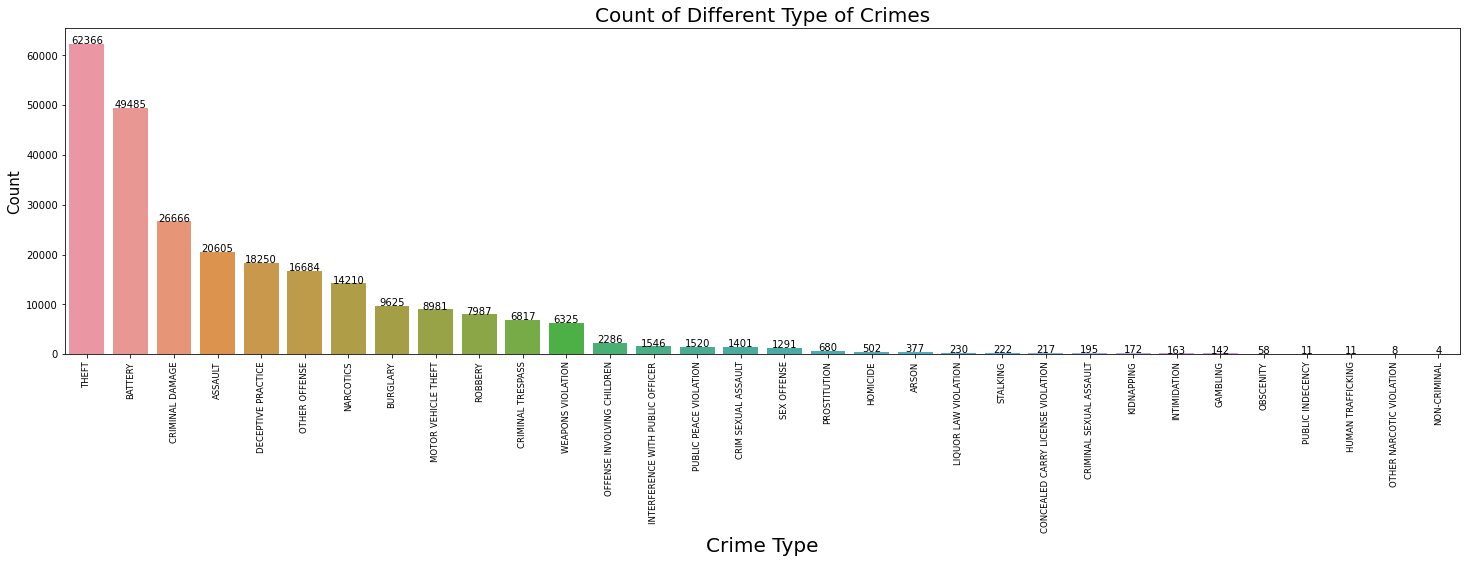

In [3]:
plt.figure(figsize=(25, 6))
plot = sns.countplot(x="Primary Type", data=df,\
                    order = df['Primary Type'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90,
                     fontsize=8.5)
for p in plot.patches:
    height = p.get_height()
    plot.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{}'.format(height),
            ha="center") 
plot.axes.set_title("Count of Different Type of Crimes",fontsize=20)
plot.set_xlabel("Crime Type",fontsize=20)
plot.set_ylabel("Count",fontsize=15)
plot

In [4]:

df1 = df[["ID","Latitude", "Longitude","Location"]]
crime_loc = df1[df1["Location"].notnull()]

# Download Census block boundaries for Chicago 
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
census_gdf["geo_11"] = census_gdf["geoid10"].map(lambda x: str(x)[:11])
blockgroup_shape = census_gdf[["geo_11", "geometry"]].dissolve(by="geo_11").reset_index()

geometry = [Point(xy) for xy in zip(crime_loc.Longitude, crime_loc.Latitude)]
crime_location = gpd.GeoDataFrame(crime_loc, crs=blockgroup_shape.crs, geometry=geometry)
temp = gpd.sjoin(blockgroup_shape, crime_location, how="left", op='intersects')
temp['Count'] = temp.groupby(['geo_11'])['ID'].transform('count')
crime_blockgroup = temp[["geo_11","Count","geometry"]].drop_duplicates()

In [5]:
# Pull ACS data
census_tables = {
    'GEO_ID': 'GEO_ID',  
    'B02001_001E': 'Race_Total', 
    "B02001_005E":'Asian',
    'B02001_002E': 'White', 
    'B02001_003E': 'Black', 
    'B19013_001E': 'Median_Income',
    "B15003_022E" : 'Bachelor_Degree',
    "B23025_005E":'Unemployment',
    "B23025_003E": 'Laborforce_Pop',
    }

acs_df = censusdata.download("acs5", 
                              2018, 
                              censusdata.censusgeo([("state", "17"), 
                                                    ("county", "031"),
                                                    ("tract", "*")]), 
                              list(census_tables.keys()))
# Rename columns 
acs_df.rename(columns=census_tables, inplace=True)

acs_df["geo_11"] = acs_df["GEO_ID"].map(lambda x: str(x)[-11:])
acs_df["black_pct"] = acs_df["Black"]/acs_df["Race_Total"]
acs_df["asian_pct"] = acs_df["Asian"]/acs_df["Race_Total"]
acs_df["white_pct"] = acs_df["White"]/acs_df["Race_Total"]
acs_df["unemp_pct"] = acs_df["Unemployment"]/acs_df["Laborforce_Pop"]
acs_df["bachelor_pct"] = acs_df["Bachelor_Degree"]/acs_df["Race_Total"]

#merged all together


demo_df = acs_df[["geo_11", "black_pct", "white_pct", "asian_pct", "unemp_pct", "bachelor_pct", "Median_Income", "Race_Total"]]
blockgroup_demo = crime_blockgroup.merge(demo_df, on="geo_11", how="left")
blockgroup_demo.crs = "EPSG:4326"
# Reproject CRS and calculate area in square kilometers
blockgroup_demo['Area'] = blockgroup_demo.to_crs('EPSG:3857').area / (10**6)
blockgroup_demo['Population_Density'] = blockgroup_demo['Race_Total'] / blockgroup_demo['Area']
blockgroup_demo["crime_rate"] = blockgroup_demo["Count"]*100000/blockgroup_demo["Race_Total"]

In [6]:
print(blockgroup_demo.shape)
blockgroup_demo.head(3)

(811, 13)


,geo_11,Count,geometry,black_pct,white_pct,asian_pct,unemp_pct,bachelor_pct,Median_Income,Race_Total,Area,Population_Density,crime_rate
0,17031010100,605,"POLYGON ((-87.66681 42.01924, -87.66780 42.019...",0.461521,0.468377,0.006192,0.070097,0.202565,37985,4522,0.690950,6544.611698,13379.035825
1,17031010201,388,"POLYGON ((-87.68234 42.01250, -87.68268 42.012...",0.375479,0.481887,0.021026,0.073414,0.134536,39549,7039,0.914568,7696.529139,5512.146612
2,17031010202,656,"POLYGON ((-87.67384 42.01265, -87.67418 42.012...",0.274544,0.443548,0.113254,0.065202,0.149018,38370,2852,0.637642,4472.726216,23001.402525


**Data Visualize**

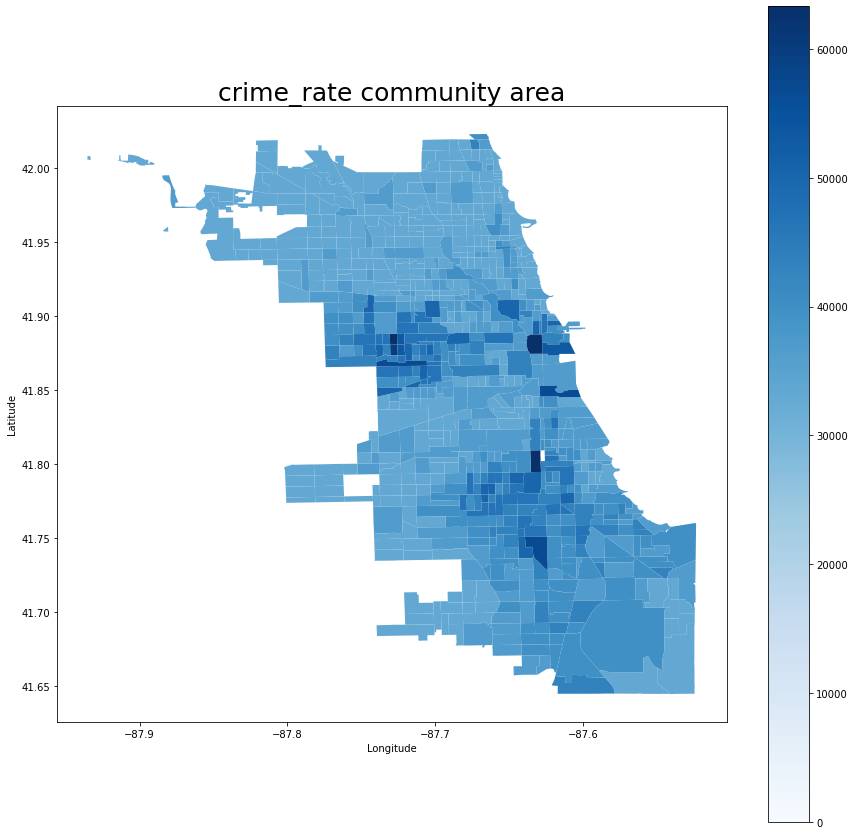

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


graph1 = blockgroup_demo.dropna()[["geometry", "crime_rate"]]

#map
vmin, vmax = graph1[ "crime_rate"].min(), graph1[ "crime_rate"].max()
fig, mp = plt.subplots(1, figsize=(15, 15))
cmap = mpl.cm.Blues(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
mp = graph1.plot(column="crime_rate", cmap=cmap, linewidth=0.8, ax=mp, edgecolor='None')
mp.set_ylabel("Latitude")
mp.set_xlabel("Longitude")
mp.set_title('crime_rate community area', fontdict={"fontsize": "25","fontweight" : "3"})

#bar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

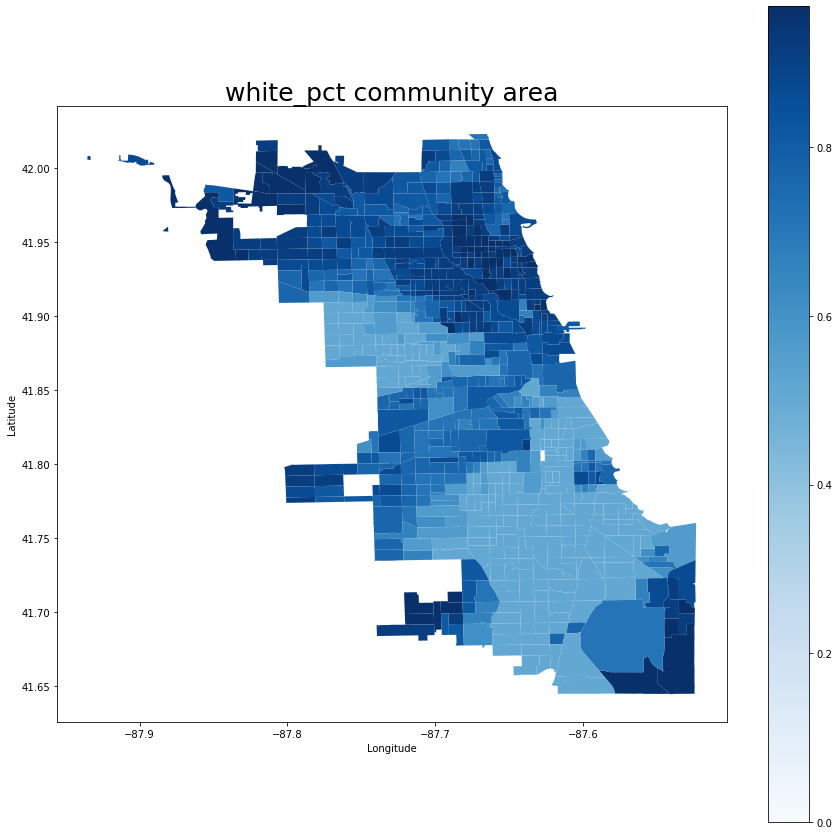

In [8]:
graph2 = blockgroup_demo.dropna()[["geometry", "white_pct"]]

#map
vmin, vmax = graph2["white_pct"].min(), graph2["white_pct"].max()
fig, mp = plt.subplots(1, figsize=(15, 15))
cmap = mpl.cm.Blues(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
mp = graph2.plot(column="white_pct", cmap=cmap, linewidth=0.8, ax=mp, edgecolor='None')
mp.set_ylabel("Latitude")
mp.set_xlabel("Longitude")
mp.set_title('white_pct community area', fontdict={"fontsize": "25","fontweight" : "3"})

#bar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

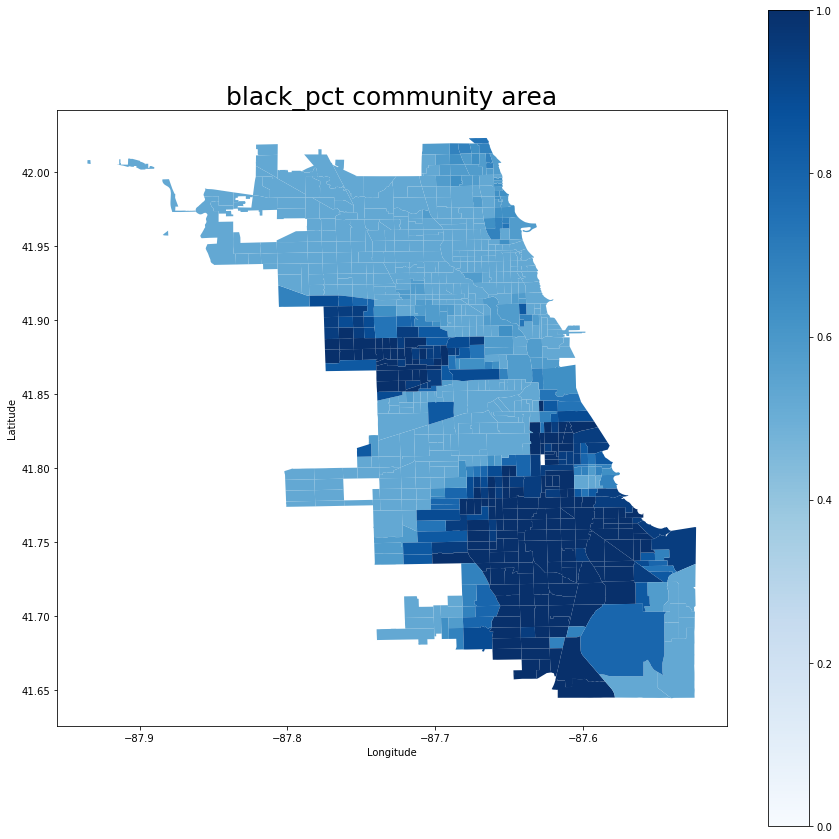

In [9]:
graph3 = blockgroup_demo.dropna()[["geometry", "black_pct"]]

#map
vmin, vmax = graph3["black_pct"].min(), graph3["black_pct"].max()
fig, mp = plt.subplots(1, figsize=(15, 15))
cmap = mpl.cm.Blues(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
mp = graph3.plot(column="black_pct", cmap=cmap, linewidth=0.8, ax=mp, edgecolor='None')
mp.set_ylabel("Latitude")
mp.set_xlabel("Longitude")
mp.set_title('black_pct community area', fontdict={"fontsize": "25","fontweight" : "3"})

#bar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

**Infrastructure data**(Other than traditional features)

**Data Sources**


1. City of Chicago Open Data  
Retrieved via API, including total units of afforable housing by block, count of grocery stores, countr of library, count of public arts, count of police station, count of abandonded houses, count of graffitti, and daily sum of traffic flow.

2. Crime and Census Data 


In [10]:
client = Socrata("data.cityofchicago.org", None)

neighborhood = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
neighborhood["geoid10"] = neighborhood["geoid10"].map(lambda x: str(x)[:11])
blockgroups = neighborhood.dissolve(by='geoid10')[['geometry']].reset_index()

In [11]:
code = {"s6ha-ppgi":["units","sum", "affordable_units"],
        "4u6w-irs9":["","size","grocery_num"],
        "x8fc-8rcq":["", "size","library_count"],
        "sj6t-9cju":["", "size", "arts_count"],
        "z8bn-74gv":["","size","police_count"],
        "7nii-7srd":["", "size", "abandoned_house"],
        "hec5-y4x5":["", "size", "graffiti_count"],
        "pfsx-4n4m":["total_passing_vehicle_volume", "sum", "traffic_sum"]}

def retrieve_gov_data(code):
    
    df = blockgroups
    
    for k,v in code.items():
        col = v[0]
        method = v[1]
        
        gdf = gpd.read_file("https://data.cityofchicago.org/resource/{}.geojson?$limit=9999999".format(k))
        gdf = gdf.dropna(subset=["geometry"])
        print(str(col)+" downloaded!")

        gdf = gpd.tools.sjoin(blockgroups, gdf, how="inner", op='intersects')
        
        if col:
            gdf = gdf.astype({col: 'int32'})
            group = gdf.groupby(['geoid10'])[col].sum().to_frame().reset_index()
        else:
            group = gdf.groupby(['geoid10']).size().to_frame().reset_index()
        
        df = pd.merge(df, group, on="geoid10", how="outer")
        print(str(col)+" merged!")
    
    df.fillna(0, inplace=True)
    df.columns = ["geoid", "geometry"] + [v[2] for v in code.values()]
    return df

In [12]:
blockgroup_infra = retrieve_gov_data(code)

units downloaded!
units merged!
 downloaded!
 merged!
 downloaded!
 merged!
 downloaded!
 merged!
 downloaded!
 merged!
 downloaded!
 merged!
 downloaded!
 merged!
total_passing_vehicle_volume downloaded!
total_passing_vehicle_volume merged!


In [13]:
print(blockgroup_infra.shape)
blockgroup_infra.head(3)

(811, 10)


,geoid,geometry,affordable_units,grocery_num,library_count,arts_count,police_count,abandoned_house,graffiti_count,traffic_sum
0,17031010100,"POLYGON ((-87.66681 42.01924, -87.66780 42.019...",0.0,1.0,0.0,0.0,0.0,7.0,377.0,0.0
1,17031010201,"POLYGON ((-87.68234 42.01250, -87.68268 42.012...",0.0,0.0,0.0,0.0,0.0,30.0,1819.0,7600.0
2,17031010202,"POLYGON ((-87.67384 42.01265, -87.67418 42.012...",57.0,2.0,0.0,1.0,0.0,7.0,1061.0,19900.0


**DATA Visualize**

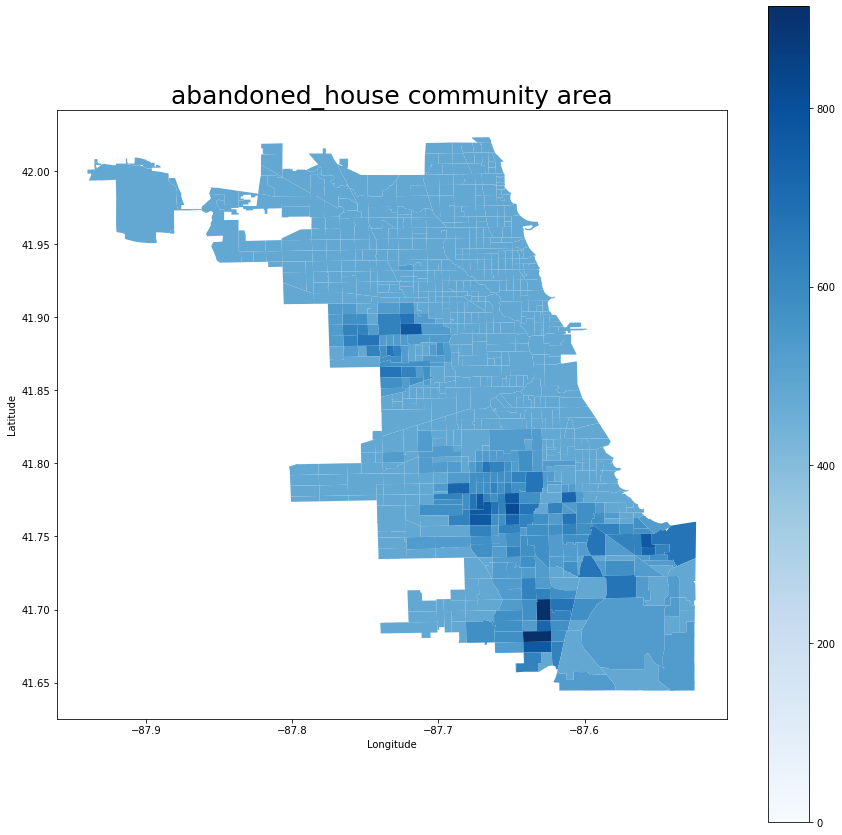

In [14]:
graph4 = blockgroup_infra.dropna()[["geometry", "abandoned_house"]]

#map
vmin, vmax = graph4["abandoned_house"].min(), graph4["abandoned_house"].max()
fig, mp = plt.subplots(1, figsize=(15, 15))
cmap = mpl.cm.Blues(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
mp = graph4.plot(column="abandoned_house", cmap=cmap, linewidth=0.8, ax=mp, edgecolor='None')
mp.set_ylabel("Latitude")
mp.set_xlabel("Longitude")
mp.set_title('abandoned_house community area', fontdict={"fontsize": "25","fontweight" : "3"})

#bar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

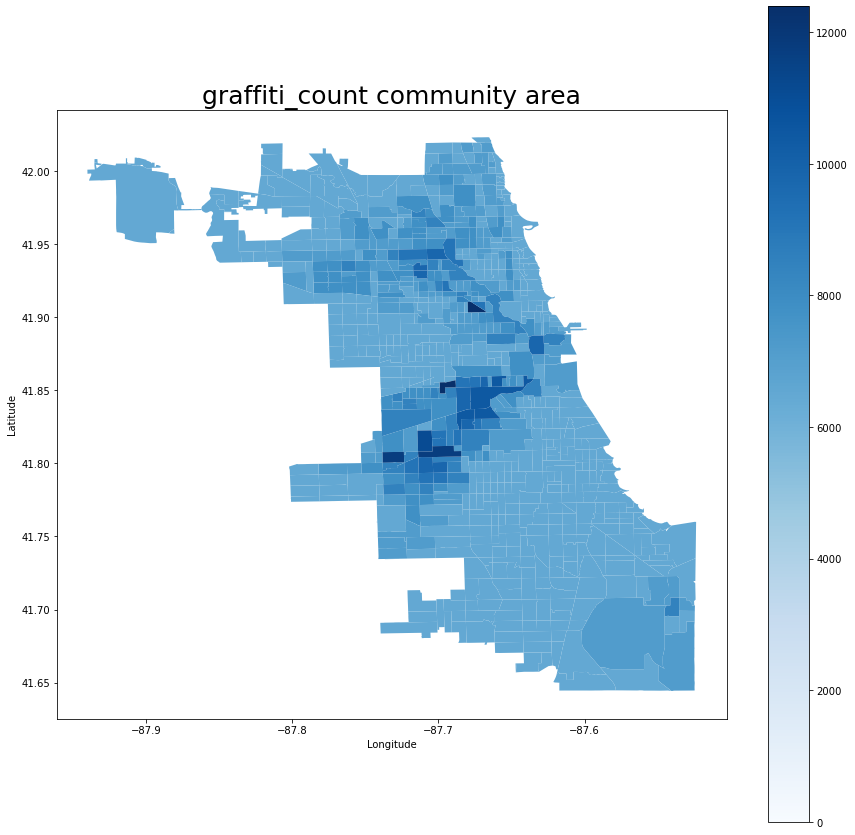

In [15]:
graph5 = blockgroup_infra.dropna()[["geometry", "graffiti_count"]]

#map
vmin, vmax = graph5["graffiti_count"].min(), graph5["graffiti_count"].max()
fig, mp = plt.subplots(1, figsize=(15, 15))
cmap = mpl.cm.Blues(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
mp = graph5.plot(column="graffiti_count", cmap=cmap, linewidth=0.8, ax=mp, edgecolor='None')
mp.set_ylabel("Latitude")
mp.set_xlabel("Longitude")
mp.set_title('graffiti_count community area', fontdict={"fontsize": "25","fontweight" : "3"})

#bar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

**merge all the node features**

In [16]:
blockgroup_infra.rename(columns = {"geoid":"geo_11"}, inplace = True)
chicago_2019_crime_demo_infra = blockgroup_infra.merge(blockgroup_demo[["geo_11", "black_pct", "white_pct","asian_pct", "unemp_pct", "bachelor_pct", "Median_Income","Population_Density","crime_rate"]], on="geo_11")
print(chicago_2019_crime_demo_infra.shape)
chicago_2019_crime_demo_infra.head(3)

(811, 18)


,geo_11,geometry,affordable_units,grocery_num,library_count,arts_count,police_count,abandoned_house,graffiti_count,traffic_sum,black_pct,white_pct,asian_pct,unemp_pct,bachelor_pct,Median_Income,Population_Density,crime_rate
0,17031010100,"POLYGON ((-87.66681 42.01924, -87.66780 42.019...",0.0,1.0,0.0,0.0,0.0,7.0,377.0,0.0,0.461521,0.468377,0.006192,0.070097,0.202565,37985,6544.611698,13379.035825
1,17031010201,"POLYGON ((-87.68234 42.01250, -87.68268 42.012...",0.0,0.0,0.0,0.0,0.0,30.0,1819.0,7600.0,0.375479,0.481887,0.021026,0.073414,0.134536,39549,7696.529139,5512.146612
2,17031010202,"POLYGON ((-87.67384 42.01265, -87.67418 42.012...",57.0,2.0,0.0,1.0,0.0,7.0,1061.0,19900.0,0.274544,0.443548,0.113254,0.065202,0.149018,38370,4472.726216,23001.402525


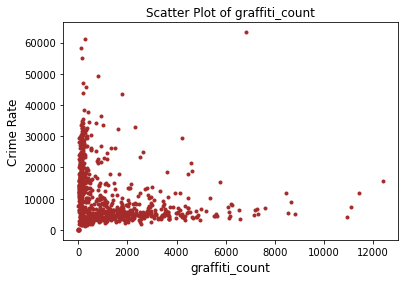

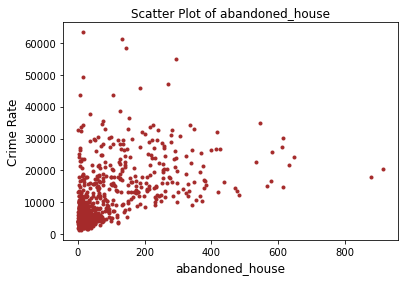

In [17]:
def scatter_plot(df, col):
    x_data = df[col].values.tolist()
    x_data = [float('nan') if x==0 else x for x in x_data]
    y_data = df["crime_rate"].values.tolist()
    y_data = [float('nan') if x_data[i] == float('nan') else y_data[i] for i in range(len(x_data))]
    plt.plot(x_data, y_data, 'o', color='brown', markersize=3)
    plt.xlabel("{}".format(col),fontsize=12)
    plt.ylabel("Crime Rate",fontsize=12)
    plt.title("Scatter Plot of {}".format(col))
    plt.show()
    
scatter_plot(chicago_2019_crime_demo_infra, "graffiti_count")
scatter_plot(chicago_2019_crime_demo_infra, "abandoned_house")

Check the correlation. 

Text(0.5, 1.0, 'Correlation between Features')

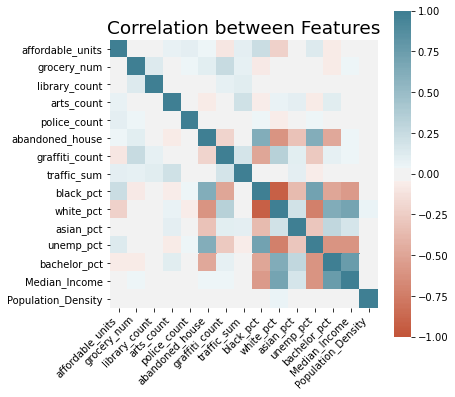

In [18]:
plt.figure(figsize=(6, 6))
corr = chicago_2019_crime_demo_infra[chicago_2019_crime_demo_infra.columns[2:17]].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=10
)
plt.title("Correlation between Features",fontsize=18.5)

Black percentage and white percentage are highly correlated, in order to aviod the Multicollinearitym, we will drop pct_white. But keep other not significance correlated variables

This is because not including a variable means the model uses less degrees of freedom, which changes the residual variance and everything computed from that (including the variance of the regression coefficients). In addition, if the non-included variable really is associated with the response, the variance in the response due to that variable will be included into the residual variance, making it larger than it otherwise would be. Thus, several things change simultaneously (the variable is correlated or not with another variable, and the residual variance), and the precise effect of dropping / including the other variable will depend on how those trade off. 

Split train test set, impute missing value using train median values.

In [19]:
data_nowhite = chicago_2019_crime_demo_infra.drop(columns=["white_pct", "geometry"])

# set up database
df_train, df_test = train_test_split(data_nowhite, test_size=0.2, random_state=0)

#impute missing value, by train set median.  
columns = data_nowhite.columns[9:15]

for c in columns:
    df_train[c] = np.where(df_train[c]>=0, df_train[c], df_train[c].median())
    df_test[c] =  np.where(df_test[c]>=0, df_test[c], df_train[c].median())
    df_train[c] = df_train[c].fillna(df_train[c].median())
    df_test[c] = df_test[c].fillna(df_train[c].median())

    
df_train["crime_rate"] = np.where(df_train["crime_rate"] != float("inf"), df_train["crime_rate"], df_train["crime_rate"].median())
df_test["crime_rate"] = np.where(df_test["crime_rate"] != float("inf"), df_test["crime_rate"], df_test["crime_rate"].median())
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


**set up traffic flow edge features**

**Steps**

1. City of Chicago Open Data
2019 taxi trip data.

2. Compute weight avgerage matrix $W$
3. Traffic Flow $= W*y_{i}$

In [20]:
TT_origin = pd.read_csv("Data/Taxi_Trips_2019.csv")

In [21]:
TT = TT_origin[["Pickup Census Tract", "Dropoff Census Tract"]]
TT = TT[TT["Pickup Census Tract"] != TT["Dropoff Census Tract"]]
TT = pd.DataFrame({"count": TT.groupby(["Pickup Census Tract", "Dropoff Census Tract"]).size()}).reset_index()
TT.head(3)

,Pickup Census Tract,Dropoff Census Tract,count
0,17031010100,17031030800,1
1,17031010100,17031063302,2
2,17031010100,17031081202,1


In [22]:
def create_trafficflow_matrix(df):

    traffic_flow = pd.Series([])
    for i in range(len(df)):
        result = 0
        val = df["geo_11"].values[i]
        temp = TT[TT["Dropoff Census Tract"] == int(val)]
        total = temp.shape[0]
        lst = temp[["Pickup Census Tract", "count"]].values
        for x in lst:
            c_rate = list(df.loc[df["geo_11"] == str(x[0])]["crime_rate"].values)
            if c_rate:
                result = (x[1]/total)*(c_rate[0]) + result
        traffic_flow[i] = result
            
    
    df.insert(15,"traffic_flow", traffic_flow)
    return

In [23]:
create_trafficflow_matrix(df_train)
create_trafficflow_matrix(df_test)
df_train.head(3)

,geo_11,affordable_units,grocery_num,library_count,arts_count,police_count,abandoned_house,graffiti_count,traffic_sum,black_pct,asian_pct,unemp_pct,bachelor_pct,Median_Income,Population_Density,traffic_flow,crime_rate
0,17031030702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033304,0.368561,0.074797,0.372114,59414.0,149852.367835,38634.416148,1909.413854
1,17031140601,0.0,0.0,0.0,0.0,0.0,17.0,758.0,23800.0,0.065255,0.213871,0.069548,0.104544,48077.0,5942.506574,17859.239301,3553.126068
2,17031031502,283.0,1.0,0.0,0.0,0.0,7.0,307.0,7500.0,0.417330,0.075898,0.085082,0.227048,25317.0,15891.344592,129370.029448,4085.142980


**Run Normalize**

In [24]:
from sklearn.preprocessing import StandardScaler

def normalize(df, scaler=None):
    '''
    If scaler is not none, use given scaler's means and sds to normalize (used for test set case)
    '''
    # Will not normalize the response (or outcomes), only the predictors (features)

    # Normalizing train set
    if(scaler is None):
      scaler = StandardScaler()
      normalized_features = scaler.fit_transform(pd.DataFrame(df.iloc[:,:-1])) 

    # Normalizing test set (with the values based on the training set)
    else:
      normalized_features = scaler.transform(pd.DataFrame(df.iloc[:,:-1]))
        
    outcomes = df.iloc[:,-1]
    normalized_df = pd.DataFrame(normalized_features)
      
    # Recover the outcomes column
    normalized_df['outcome'] = outcomes.tolist() #We use .tolist() to avoid conflict given different index between normalized_df and outcomes
    
    # Recover the original indices and column names                                          
    normalized_df.index=df.index
    normalized_df.columns=df.columns

    return normalized_df, scaler
  
    

df_train, scaler = normalize(df_train)
df_test, _ = normalize(df_test, scaler)

df_train["log_crime_rate"] = np.log(df_train['crime_rate'])
df_test["log_crime_rate"] = np.log(df_test['crime_rate'])
df_train = df_train.replace({float("-inf"): 0})
df_test = df_test.replace({float("-inf"): 0})



df_test.describe().loc[['mean', 'std']]

,geo_11,affordable_units,grocery_num,library_count,arts_count,police_count,abandoned_house,graffiti_count,traffic_sum,black_pct,asian_pct,unemp_pct,bachelor_pct,Median_Income,Population_Density,traffic_flow,crime_rate,log_crime_rate
mean,0.077135,0.133778,-0.084431,-0.082172,0.009716,0.117625,-0.059461,-0.039685,-0.026114,0.175815,-0.156699,0.029073,-0.048625,-0.089671,-0.045061,-0.178933,10811.141880,8.915087
std,0.999868,1.460338,0.920227,0.886692,1.071507,1.310438,0.809882,1.084479,0.861912,1.041568,0.671391,0.887993,0.881637,0.956465,0.023577,0.121042,8137.462623,1.210160


In [25]:
df_train.describe().loc[['mean', 'std']]

,geo_11,affordable_units,grocery_num,library_count,arts_count,police_count,abandoned_house,graffiti_count,traffic_sum,black_pct,asian_pct,unemp_pct,bachelor_pct,Median_Income,Population_Density,traffic_flow,crime_rate,log_crime_rate
mean,1.347630e-12,5.071389e-17,5.208454e-17,2.193033e-17,0.000000,2.741291e-18,1.507710e-17,0.000000,3.289550e-17,-2.741291e-18,-4.934325e-17,5.208454e-17,1.850372e-16,0.000000,-1.644775e-17,-2.055969e-17,10764.413602,8.867562
std,1.000772e+00,1.000772e+00,1.000772e+00,1.000772e+00,1.000772,1.000772e+00,1.000772e+00,1.000772,1.000772e+00,1.000772e+00,1.000772e+00,1.000772e+00,1.000772e+00,1.000772,1.000772e+00,1.000772e+00,9512.577743,1.253827


In [26]:
train_features = df_train[df_train.columns[1:16]]
train_targets = df_train['crime_rate']
test_features = df_test[df_test.columns[1:16]]
test_targets = df_test['crime_rate']

#take the log for crime_rate
#train_targets = df_train['log_crime_rate']
#test_targets = df_test['log_crime_rate']

**Run the regression**

In [27]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score



regr = linear_model.LinearRegression()
regr.fit(train_features, train_targets)

#print('Intercept: \n', regr.intercept_)
#print('Coefficients: \n', regr.coef_)

target_predict = regr.predict(test_features)


def metrics(target_predict,test_targets,train_features,train_targets,regr,output=True):
    
    bias = mean_squared_error(regr.predict(train_features),train_targets)
    mse = mean_squared_error(target_predict,test_targets)
    rss = np.sum((target_predict - test_targets) ** 2)
    variance = regr.score(train_features, train_targets)
    
    if output:
        print("Bias: %.2f" % bias)   
        print("Mean squared error: %.2f" % mse)
        print("RSS: %.2f" % rss)
        print('Variance score: %.2f\n' % variance)
    
    return(bias,mse,rss,variance)

ev = {}
ev['Linear Regression'] = metrics(target_predict,test_targets,train_features,train_targets,regr)

Bias: 38191793.80
Mean squared error: 34240474.16
RSS: 5581197288.65
Variance score: 0.58



Try different Regularization:
* Lasso: Penalizes the sum of absolute values of all parameter coefficients.
* Ridge: Penalizes the sum of squares of all parameter coefficients.
* Elastic Network: Combines Lasso and Ridge Regression

In [28]:
print(list(df_train), '\n\n')

ls = linear_model.Lasso(alpha=0.5)
rg = linear_model.Ridge(alpha=0.5)
en = linear_model.ElasticNet(alpha=0.5)

models = [(ls, 'Lasso'),
           (rg, 'Ridge'),
           (en, 'Elastic Net')]

for m in models:
    (model,name) = m
    model.fit(train_features,train_targets)
    target_predict = model.predict(test_features)
    print('{}\n{}\n'.format(name,model.coef_))
    ev[name] = metrics(target_predict,test_targets,train_features,train_targets,model)


['geo_11', 'affordable_units', 'grocery_num', 'library_count', 'arts_count', 'police_count', 'abandoned_house', 'graffiti_count', 'traffic_sum', 'black_pct', 'asian_pct', 'unemp_pct', 'bachelor_pct', 'Median_Income', 'Population_Density', 'traffic_flow', 'crime_rate', 'log_crime_rate'] 


Lasso
[ 719.04690742  -16.23075033  -67.86947833  496.43844204 1013.75716063
  882.92818848  753.27199492 1162.87744777 5607.08350695 -259.51855015
  510.33408213  298.500287   -425.11738412 -107.52851909 2422.88947751]

Bias: 38191799.44
Mean squared error: 34236278.82
RSS: 5580513447.03
Variance score: 0.58

Ridge
[ 720.32237414  -17.25515866  -68.09263672  496.8919472  1013.54505102
  885.99369105  749.45774499 1164.58387778 5593.16423003 -261.83632877
  515.54918176  301.10027127 -429.37761668 -108.06547053 2421.13067071]

Bias: 38191854.25
Mean squared error: 34221515.76
RSS: 5578107068.39
Variance score: 0.58

Elastic Net
[ 817.78599894  -40.426026    -22.20491197  454.62063786  855.37018297
 11

Polynomial degree of 2

In [29]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2, include_bias=False)
p_train_features = pf.fit_transform(train_features)
p_test_features = pf.fit_transform(test_features)

pregr = linear_model.LinearRegression()
pregr.fit(p_train_features,train_targets)

p_target_predict = pregr.predict(p_test_features)


ev['Linear Polynomial'] = metrics(p_target_predict,test_targets,p_train_features,train_targets,pregr)

Bias: 19619775.02
Mean squared error: 173767904.08
RSS: 28324168365.13
Variance score: 0.78



BayesianRidge

In [30]:
from sklearn.linear_model import BayesianRidge

lregr = linear_model.BayesianRidge()
lregr.fit(train_features, train_targets)
target_predict = lregr.predict(test_features)

ev['Bayesian Ridge'] = metrics(target_predict,test_targets,train_features,train_targets,regr)

Bias: 38191793.80
Mean squared error: 33768811.29
RSS: 5504316239.51
Variance score: 0.58



Poisson Regressor

In [31]:
from sklearn.linear_model import PoissonRegressor

lregr = linear_model.PoissonRegressor()
lregr.fit(train_features, train_targets)
target_predict = lregr.predict(test_features)

ev['Poisson Regressor'] = metrics(target_predict,test_targets,train_features,train_targets,regr)

Bias: 38191793.80
Mean squared error: 36702577.30
RSS: 5982520100.11
Variance score: 0.58



Performance Plot

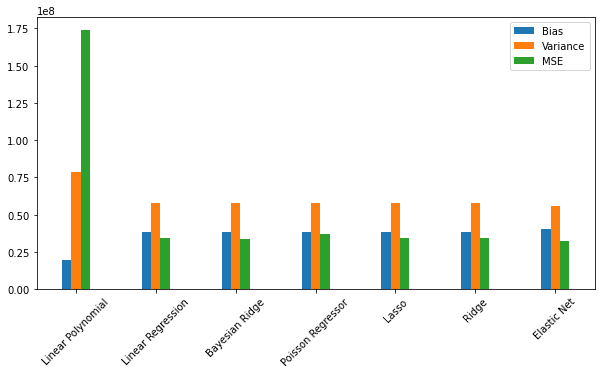

In [32]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

mdf = pd.DataFrame(
    ev
).transpose()

mdf.index.name = 'Type'
mdf.rename(columns={0:'Bias',1:'MSE',2:'RSS',3:'Variance'},inplace=True)
mdf.sort_values(by=['Bias'],inplace=True)

labels = mdf.index.values
x = np.arange(len(labels))
width = 0.35  


fix, ax = plt.subplots()
rects = ax.bar(x - width/3, mdf['Bias'], width/3, label='Bias')
rects = ax.bar(x, mdf['Variance']*1e8, width/3, label='Variance')
rects = ax.bar(x + width/3, mdf['MSE'], width/3, label='MSE')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.show()

**Check the OLS Signifiance**
1. demographic features and infrastructure features
2. log_crime_rate as outcome with demographic and infrastructure
3. demographic features only


$\vec{y}=\vec{\alpha}^{T} \vec{x}+\beta^{T} W \vec{y}+\vec{\epsilon}$

where $\vec{x}$ represents the node features, including demographics and infrastructure, W is the flow matrix of taxi flow

In [33]:
#check the coefficients signficance. 

import statsmodels.api as sm
from scipy import stats

x = sm.add_constant(train_features)
est = sm.OLS(train_targets, x).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             crime_rate   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     57.54
Date:                Thu, 11 Jun 2020   Prob (F-statistic):          1.97e-107
Time:                        16:40:58   Log-Likelihood:                -6575.9
No. Observations:                 648   AIC:                         1.318e+04
Df Residuals:                     632   BIC:                         1.326e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.076e+04    245

In [34]:
train_features = df_train[df_train.columns[9:16]]
train_targets = df_train['crime_rate']
test_features = df_test[df_test.columns[9:16]]
test_targets = df_test['crime_rate']

x = sm.add_constant(train_features)
est2 = sm.OLS(train_targets, x).fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             crime_rate   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     104.0
Date:                Thu, 11 Jun 2020   Prob (F-statistic):          3.18e-101
Time:                        16:40:58   Log-Likelihood:                -6608.8
No. Observations:                 648   AIC:                         1.323e+04
Df Residuals:                     640   BIC:                         1.327e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.076e+04    256

$\log(\vec{y})=\vec{\alpha}^{T} \vec{x}+\beta^{T} W \vec{y}+\vec{\epsilon}$

where $\vec{x}$ represents the node features, including demographics and infrastructure, W is the flow matrix of taxi flow

In [35]:
#take the log for crime_rate

train_features = df_train[df_train.columns[1:16]]
test_features = df_test[df_test.columns[1:16]]
train_targets = df_train['log_crime_rate']
test_targets = df_test['log_crime_rate']


x = sm.add_constant(train_features)
est3 = sm.OLS(train_targets, x).fit()
print(est3.summary())

                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     37.81
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           1.01e-77
Time:                        16:40:59   Log-Likelihood:                -858.03
No. Observations:                 648   AIC:                             1748.
Df Residuals:                     632   BIC:                             1820.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.8676      0

bootstrap

In [36]:
train_features = df_train[df_train.columns[1:16]]
train_targets = df_train['crime_rate']
test_features = df_test[df_test.columns[1:16]]
test_targets = df_test['crime_rate']


#run bootstrap 10000 times. 
columns = ["const"] + list(df_train.columns[1:16])
result = pd.DataFrame(columns = columns)

for x in range(10000):
    boot = resample(df_train, replace=True, n_samples=648, random_state=x)
    train_features_bs = boot[boot.columns[1:16]]
    train_targets_bs = boot['crime_rate']
    regr = linear_model.LinearRegression()
    regr.fit(train_features_bs, train_targets_bs)
    temp = pd.DataFrame([[regr.intercept_] + list(regr.coef_)], columns = columns)
    result = result.append(temp,ignore_index=True)

des = result.describe().loc[['mean', 'std']]
t_value = []
for i in range(des.shape[1]):
    t = des.values[0][i]/des.values[1][i]
    t_value.append(t)

temp = pd.DataFrame([t_value],columns = columns)
des = des.append(temp,ignore_index=True)
des

,const,affordable_units,grocery_num,library_count,arts_count,police_count,abandoned_house,graffiti_count,traffic_sum,black_pct,asian_pct,unemp_pct,bachelor_pct,Median_Income,Population_Density,traffic_flow
0,10699.717802,694.734052,14.153827,-77.115989,603.884133,1014.254494,895.403699,742.343381,945.320368,5590.424277,-255.983661,524.194615,344.958685,-468.328141,-1636.185580,2459.332271
1,394.531843,421.974330,247.411292,232.616671,659.176643,403.542390,417.144712,206.519876,505.766811,567.135028,193.293273,665.431206,425.524197,429.213603,6662.399366,621.998745
2,27.120036,1.646389,0.057208,-0.331515,0.916119,2.513378,2.146506,3.594537,1.869083,9.857307,-1.324328,0.787752,0.810668,-1.091131,-0.245585,3.953918


First line: Coefficient Mean; 
Second line: Coefficient Standard Error; 
Third line: T value of null hypothesis (coefficient = 0). 

results are pretty similar with our OLS regression, and the variables that are still statistically significant are: police_count, abandoned_house, graffiti_count, black_pct, traffic_flow. 

In [37]:
output = df_train.reset_index(drop = True)
output.to_csv("output.csv")

Following analysis will be in STATA files.

### 4. Synthetic Control Method

**Data Sources**

1. FBI Crime Data
State-levelopen dataset including 2010~2018

2. Yearly ACS Demographic features data


In [38]:
import string
import us
def read_crime_data(year):
    '''
    Read in crime data
    '''
    # Read in data from xls
    df = eval('pd.read_excel("Data/{}.xls")'.format(year))

    # Remove empty columns and rows
    df = df.dropna(axis=1, how='all').dropna(thresh=3)
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    df["State"] = df["State"].fillna(method='ffill')
    df = df.fillna(0)
    df = df.reset_index(drop=True)
    return df

In [39]:
#["20","203", "KANSAS", "Wichita"]["41","051","OREGON","Portland"] ["19","057","IOWA", "Des Moines"] droped

#top 5 largest city in united state and other big cities in the state cluster in the same group with IL

list_of_city = [["17", "031", "ILLINOIS","Chicago"],["48","225", "TEXAS","Houston"], ["32","003","NEVADA", "Las Vegas Metropolitan Police Department" ],\
                ["55", "079","WISCONSIN", "Milwaukee" ], ['31', "055", "NEBRASKA","Omaha"], ["42","101", "PENNSYLVANIA", "Philadelphia"], \
                 ["38","017", "NORTH DAKOTA", "Fargo"] ,\
                ["56","021", "WYOMING", "Cheyenne"], ["36", "061", "NEW YORK", "New York"], ["10","003", "DELAWARE", "Wilmington"], ["06","037", "CALIFORNIA", "Los Angeles"]]
test = pd.DataFrame()
census_tables = {
        'GEO_ID': 'GEO_ID',  
        'B02001_001E': 'Race_Total', 
        "B02001_005E": 'Asian',
        'B02001_002E': 'White', 
        'B02001_003E': 'Black', 
        'B19013_001E': 'Median_Income'
        }
for year in range(2010, 2019):
    for x in list_of_city:
        acs_df_temp = censusdata.download("acs5", 
                                      year, 
                                      censusdata.censusgeo([("state", x[0]), 
                                                            ("county", x[1])]), 
                                      list(census_tables.keys()))


        acs_df_temp.rename(columns=census_tables, inplace=True)

        #acs_df["geo_11"] = acs_df["GEO_ID"].map(lambda x: str(x)[-11:])
        acs_df_temp["black_pct"] = acs_df_temp["Black"]/acs_df_temp["Race_Total"]
        acs_df_temp["asian_pct"] = acs_df_temp["Asian"]/acs_df_temp["Race_Total"]
        acs_df_temp["white_pct"] = acs_df_temp["White"]/acs_df_temp["Race_Total"]
        
        df = read_crime_data(year)
        rate = df[(df["State"] == x[2]) & (df["City"] == x[3])][df.columns[2:8]]
        rate["violent_crime_rate"] = (rate[rate.columns[2]] + rate[rate.columns[3]] + rate[rate.columns[4]] + rate[rate.columns[5]])*100000/rate[rate.columns[0]]
        crime_rate = rate["violent_crime_rate"].values[0]
        
        demo_df = acs_df_temp[[ "black_pct", "white_pct", "asian_pct", "Median_Income", "Race_Total"]]
        demo_df["years"] = year
        demo_df["city"] = x[3]
        demo_df["crime_rate"] = crime_rate
        test = test.append(demo_df)

In [40]:
output_syn = test.reset_index(drop = True)
output_syn = output_syn.replace({"Las Vegas Metropolitan Police Department" : "Las Vegas"})
#output for syn
output_syn.to_csv("output_syn.csv")
output_syn.head(3)

,black_pct,white_pct,asian_pct,Median_Income,Race_Total,years,city,crime_rate
0,0.251954,0.541154,0.061214,53942,5172848,2010,Chicago,1002.311860
1,0.257677,0.655148,0.003891,31929,23642,2010,Houston,986.075860
2,0.102188,0.697685,0.083341,56258,1895521,2010,Las Vegas,892.967458


Following analysis will be in STATA files.